<i>Author: Timothy Lang (timothy.j.lang@nasa.gov)</i>

##### Import needed modules

In [11]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import multidop
import pyart
import tempfile
import os
import glob
import time
%matplotlib inline

##### Ingest radar volumes using `pyart`.

In [2]:
basepath = '/Volumes/Transcend/Data/MultiDop/20090410_supercell/'
f1 = glob.glob(basepath +'KHTX/*.uf')
f2 = glob.glob(basepath +'ARMOR/*.uf')

In [3]:
r1 = pyart.aux_io.radx.read_radx(f1[0])
r2 = pyart.aux_io.radx.read_radx(f2[0])

##### Rename variable fields to be consistent between radars.

In [4]:
# If you needed to dealias or perform other corrections,
# this would be the time to start doing that.
cp = deepcopy(r1.fields['RE']['data'])
r1.add_field_like('RE', 'DT', cp, replace_existing=True)
cp = deepcopy(r1.fields['VE']['data'])
r1.add_field_like('VE', 'VT', cp, replace_existing=True)

In [5]:
cp = deepcopy(r2.fields['CZ']['data'])
r2.add_field_like('CZ', 'DT', cp, replace_existing=True)
cp = deepcopy(r2.fields['VR']['data'])
r2.add_field_like('VR', 'VT', cp, replace_existing=True)

In [6]:
# The analysis engine currently expects the "missing_value" attribute
r1.fields['DT']['missing_value'] = 1.0 * r1.fields['DT']['_FillValue']
r2.fields['DT']['missing_value'] = 1.0 * r2.fields['DT']['_FillValue']
r1.fields['VT']['missing_value'] = 1.0 * r1.fields['VT']['_FillValue']
r2.fields['VT']['missing_value'] = 1.0 * r2.fields['VT']['_FillValue']

##### Now grid the volumes and add azimuths and elevations afterward.

In [7]:
def grid_radar(radar, grid_shape=(20, 301, 301), xlim=(-150000, 150000),
               ylim=(-150000, 150000), zlim=(1000, 20000),
               fields=['DT', 'VT'], origin=None):
    bt = time.time()
    radar_list = [radar]
    if origin is None:
        origin = (radar.latitude['data'][0],
                  radar.longitude['data'][0])
    grid = pyart.map.grid_from_radars(
        radar_list, grid_shape=grid_shape,
        grid_limits=(zlim, ylim, xlim),
        grid_origin=origin, fields=fields,
        gridding_algo='map_gates_to_grid', grid_origin_alt=0.0)
    print(time.time()-bt, 'seconds to grid radar')
    return grid

In [8]:
g1 = grid_radar(r1, origin=(r2.latitude['data'][0], r2.longitude['data'][0]),
                xlim=(-100000, 50000), ylim=(0, 150000), grid_shape=(20, 151, 151))
g2 = grid_radar(r2, origin=(r2.latitude['data'][0], r2.longitude['data'][0]),
                xlim=(-100000, 50000), ylim=(0, 150000), grid_shape=(20, 151, 151))

10.1378121376 seconds to grid radar
3.39122200012 seconds to grid radar


In [9]:
# The analysis engine requires azimuth and elevation to be part of the grid.
# This information is computed from the grid geometry.
g1 = multidop.angles.add_azimuth_as_field(g1)
g2 = multidop.angles.add_azimuth_as_field(g2)
g1 = multidop.angles.add_elevation_as_field(g1)
g2 = multidop.angles.add_elevation_as_field(g2)

In [10]:
# Save the input grids for later.
pyart.io.write_grid('khtx_supercell.nc', g1)
pyart.io.write_grid('armor_supercell.nc', g2)

//anaconda/lib/python2.7/site-packages/pyart/io/cfradial.py:786: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  ncvar[:] = data[:]
//anaconda/lib/python2.7/site-packages/pyart/io/cfradial.py:786: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  ncvar[:] = data[:]
//anaconda/lib/python2.7/site-packages/pyart/io/cfradial.py:786: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  ncvar[:] = data[:]
//anaconda/lib/python2.7/site-packages/pyart/io/cfradial.py:786: DeprecationWarning: using a boolean instead of an integer will result in an error in the future
  ncvar[:] = data[:]


##### Now set up and execute the multi-Doppler processing. Save the output to a `pyart`-compatible CF grid.

In [23]:
# You don't have to define everything. Most of these keywords are default values.
# If you don't define something the program will provide a default value.
# Check parameters.py for what keyword default values are.
localfile = tempfile.NamedTemporaryFile()
pd = {'dir': './',
      'x': [-100000.0, 1000.0, 151],
      'y': [0.0, 1000.0, 151],
      'z': [1000.0, 1000.0,  20],
      'grid': [g1.origin_longitude['data'][0], g1.origin_latitude['data'][0], 0.0],
      'files': ['khtx_supercell.nc',
                'armor_supercell.nc'],
      'radar_names': ['KHTX', 'ARMOR'],
      'refl': 'DT',  # Name of reflectivity field. Must be common between radars.
      'vt': 'VT',  # Name of velocity field. Must be common between radars.
      'bgfile': None,
      'writeout': localfile.name,
      'min_cba': 20.0,  # Minimum beam-crossing angle
      'calc_params': 'calc_example.dda',
      'anel': 1,
      'laplace': 0,
      'read_dataweights': 2,
      'max_dist': 10.0,
      'cutoff': 0.0,
      'UT': 0.0,
      'VT': 0.0,
      'output_error': 0,
      'weak_height': -1,
      'upper_bc': 1,
      'itmax_frprmn': [200, 10],
      'itmax_dbrent': 200,
      'C1b': 1.0,  # Data weighting factor
      'C2b': 10.0,  # Mass continuity weighting factor
      'C3b': 0,  # Vorticity weighting factor
      'C4b': 1.0,  # Horizontal smoothing factor
      'C5b': 0.0,  # Vertical smoothing factor
      'C8b': 0.0,  # Sounding factor
      'vary_weights': 0,
      'filter': ['none', '', ''],
      'cvg_opt_bg': [1, 1, 1],
      'cvg_sub_bg': [0, 0, 0],
      'cvg_opt_fil': [0, 1, 1],
      'cvg_sub_fil': [0, 0, 0],
      'cvg_bg': [0, 0, 0],
      'cvg_fil': [0, 0, 0],
      'sseq_trip': [1.0, 1.0, 0.0]
     }
pf = multidop.parameters.ParamFile(pd, 'example.dda')
pf = multidop.parameters.CalcParamFile(pd, 'calc_example.dda')

In [24]:
# Unfortunately, text output from the analysis engine (DDA) will not display
# until after the program completes. Expect this step to take several minutes.
bt = time.time()
multidop.execute.do_analysis('example.dda')
print((time.time()-bt)/60.0, 'minutes to process')

DDA 0.8.2
./DDA: reading calculation parameters from calc_example.dda.
Changing working directory to ./
x: -100000.000000 to 50000.000000 in 150 steps of 1000.000000
y: 0.000000 to 150000.000000 in 150 steps of 1000.000000
z: 1000.000000 to 20000.000000 in 19 steps of 1000.000000
z_min=1000, cutoff=0
UT=0, VT=0
Anelastic mass cons
First-order smoothness constraint
Minimum beam crossing angle = 20 degrees
Py-ART grids for analyis and all radars must match to within (dx, dy, dz) < (10 10 10) meters.
Reading Py-ART filekhtx_supercell.nc
armor_supercell.nc

Radar positions:  (62656.4,31821.4) (0.123459,-0.013841)
Computing coverage: 155907 verification points out of 456020 total points.
radar0 249854 obs. radar1 163806 obs. 413660 total obs.
Analyzed obs = 413660. Mean Vr = 23.4908
C1b=1 C2b=10 C3b=0 C4b=1 C5b=0 C6b=0 C7b=1 C8b=0
C2a=10 C3a=0 C4a=1 C5a=0 C6a=0 C7a=1 C8a=0
Weighting all obs equally!
GradCheck: rchek = 1e+10. fx1 = 281865
GradCheck: gxnn = 2979.22
GradCheck: j = 1. fx2 = 9.2

In [25]:
# Baseline output is not CF or Py-ART compliant. This function fixes that.
# This is why we wrote the original output to a tempfile that can be safely removed.
# The final grid will have all wind solutions outside the coverage region masked.
fname = 'cf_compliant_grid.nc'
final_grid = multidop.grid_io.make_new_grid([g1, g2], localfile.name)
final_grid.write(fname)
localfile.close()

##### Finally, let's check the results!

In [30]:
pyart_grid = pyart.io.read_grid(fname)
print(pyart_grid.fields.keys())

[u'eastward_wind', u'reflectivity', u'upward_air_velocity', u'northward_wind']


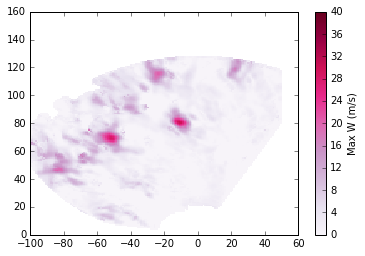

In [27]:
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0),
                    vmin=0, vmax=40, cmap='PuRd')
plt.colorbar(cs, label='Max W (m/s)')

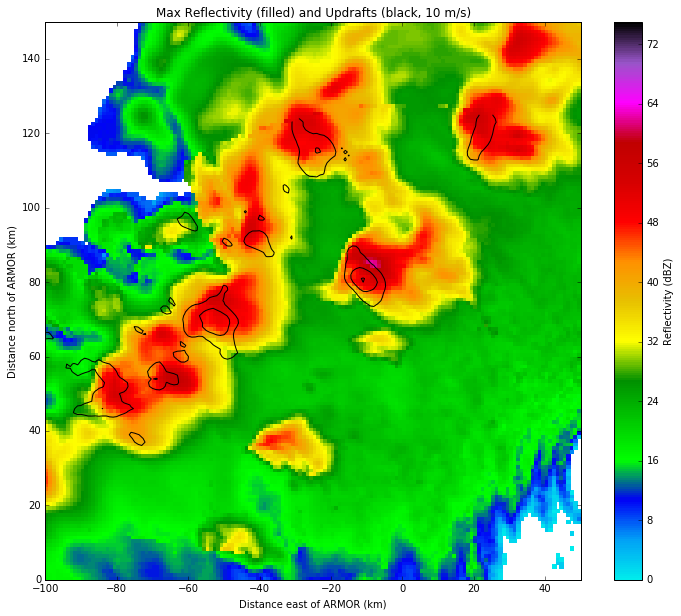

In [28]:
fig = plt.figure(figsize=(12, 10))
DZcomp = np.amax(pyart_grid.fields['reflectivity']['data'], axis=0)
x, y = np.meshgrid(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'])
cs = plt.pcolormesh(0.001*pyart_grid.x['data'], 0.001*pyart_grid.y['data'],
                    DZcomp, vmin=0, vmax=75, cmap='pyart_NWSRef')
Wcomp = np.amax(pyart_grid.fields['upward_air_velocity']['data'], axis=0)
plt.contour(x, y, Wcomp, levels=[10, 20, 30, 40], colors=['k', 'k', 'k'])
plt.xlim(-100, 50)
plt.ylim(0, 150)
plt.colorbar(cs, label='Reflectivity (dBZ)')
plt.title('Max Reflectivity (filled) and Updrafts (black, 10 m/s)')
plt.xlabel('Distance east of ARMOR (km)')
plt.ylabel('Distance north of ARMOR (km)')

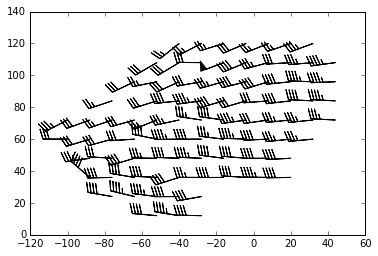

In [29]:
thin = 12
ilev = 7
plt.barbs(x[::thin, ::thin], y[::thin, ::thin],
          pyart_grid.fields['eastward_wind']['data'][ilev][::thin, ::thin],
          pyart_grid.fields['northward_wind']['data'][ilev][::thin, ::thin])